In [2]:
# Step 0: Install required libraries (run once)
# Note: -U upgrades to latest compatible wheels for Python 3.13.

import sys
!{sys.executable} -m pip install -U pip setuptools wheel
!{sys.executable} -m pip install -U numpy pandas scikit-learn seaborn matplotlib
!{sys.executable} -m pip install -U xgboost lightgbm
# TensorFlow CPU build; if this fails or is heavy, we will auto-switch to a PCA fallback later.
!{sys.executable} -m pip install -U tensorflow==2.17.0 --only-binary=:all: --upgrade-strategy eager


  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/1.8 MB ? eta -:--:--
   ----------- ---------------------------- 0.5/1.8 MB 1.3 MB/s eta 0:00:01
   ----------------- ---------------------- 0.8/1.8 MB 1.3 MB/s eta 0:00:01
   ----------------------- ---------------- 1.0/1.8 MB 1.3 MB/s eta 0:00:01
   ----------------------------- ---------- 1.3/1.8 MB 1.3 MB/s eta 0:00:01
   ----------------------------------- ---- 1.6/1.8 MB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 1.8/1.8 MB 1.2 MB/s eta 0:00:00
Using cached setuptools-80.9.0-py3-none-any.whl (1.2 MB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.8.2
    Uninstalling setuptools-75.8.2:
      Successfully uninstalled setuptools-75.8.2
  Attempting uninstall: pip
    Found exi

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.3 which is incompatible.


  Using cached lightgbm-4.6.0-py3-none-win_amd64.whl.metadata (17 kB)
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.3/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.5/56.8 MB 1.1 MB/s eta 0:00:50
    --------------------------------------- 0.8/56.8 MB 1.2 MB/s eta 0:00:48
    --------------------------------------- 1.0/56.8 MB 1.2 MB/s eta 0:00:47
    --------------------------------------- 1.3/56.8 MB 1.2 MB/s eta 0:00:46
   - -------------------------------------- 1.6/56.8 MB 1.2 MB/s eta 0:00:47
   - -------------------------------------- 1.8/56.8 MB 1.2 MB/s eta 0:00:46
   - -------------------------------------- 2.1/56.8 MB 1.2 MB/s eta 0:00:46
   - -------------------------------------- 2.4/56.8 MB 1.2 MB/s eta 0:00:45
   - -------------------------------------- 2.6/56.8 MB 1.2 MB/s eta 0:00:45
   -- ---------------------

ERROR: Could not find a version that satisfies the requirement tensorflow==2.17.0 (from versions: 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.17.0


In [4]:
# Cell 1: Setup, install, and bind dataset paths (using your exact files)

import sys, os, warnings
warnings.filterwarnings("ignore")

# Install/upgrade dependencies
!{sys.executable} -m pip install -U pip setuptools wheel
!{sys.executable} -m pip install -U numpy pandas scikit-learn seaborn matplotlib
!{sys.executable} -m pip install -U xgboost lightgbm

# Optional TensorFlow for autoencoder; will fallback if not available
try:
    !{sys.executable} -m pip install -U tensorflow==2.17.0 --only-binary=:all: --upgrade-strategy eager
    TF_REQUESTED = True
except Exception as e:
    print("TensorFlow install attempt skipped/failed:", e)
    TF_REQUESTED = False

# Imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, average_precision_score,
    precision_recall_fscore_support
)
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

# Optional TF import
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    TF_AVAILABLE = True
except Exception as e:
    print("TensorFlow not available; will use PCA-reconstruction fallback for anomaly:", e)
    TF_AVAILABLE = False

import matplotlib.pyplot as plt
import seaborn as sns

# Dataset paths (exactly as provided)
TRAIN_CSV = r"D:\Deep_Learning_projects\Intelligent Network Intrusion Detection System\Data_Set\Training and Testing Sets\UNSW_NB15_training-set.csv"
TEST_CSV  = r"D:\Deep_Learning_projects\Intelligent Network Intrusion Detection System\Data_Set\Training and Testing Sets\UNSW_NB15_testing-set.csv"

# Optional extras directory (not used in first run)
EXTRAS_DIR = r"D:\Deep_Learning_projects\Intelligent Network Intrusion Detection System\Data_Set\Extras"

assert os.path.exists(TRAIN_CSV), f"Training CSV not found: {TRAIN_CSV}"
assert os.path.exists(TEST_CSV),  f"Testing CSV not found: {TEST_CSV}"

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
if 'tf' in globals() and TF_AVAILABLE:
    tf.random.set_seed(RANDOM_STATE)

print("Environment ready.")
print("TensorFlow available:", TF_AVAILABLE)
print("Train path:", TRAIN_CSV)
print("Test path:", TEST_CSV)
print("Extras path (optional):", EXTRAS_DIR)


Environment ready.
TensorFlow available: True
Train path: D:\Deep_Learning_projects\Intelligent Network Intrusion Detection System\Data_Set\Training and Testing Sets\UNSW_NB15_training-set.csv
Test path: D:\Deep_Learning_projects\Intelligent Network Intrusion Detection System\Data_Set\Training and Testing Sets\UNSW_NB15_testing-set.csv
Extras path (optional): D:\Deep_Learning_projects\Intelligent Network Intrusion Detection System\Data_Set\Extras


ERROR: Could not find a version that satisfies the requirement tensorflow==2.17.0 (from versions: 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.17.0


In [5]:
# Cell 2: Load UNSW-NB15 and basic inspection
# Purpose: Read train/test CSVs, verify schema, and separate categorical vs numerical columns.

import pandas as pd
import numpy as np

# Load CSVs
train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("Columns (first 10):", list(train_df.columns)[:10])

# Key columns expected by UNSW-NB15
assert "label" in train_df.columns and "label" in test_df.columns, "label column missing"
assert "attack_cat" in train_df.columns and "attack_cat" in test_df.columns, "attack_cat column missing"

# Identify categorical and numeric columns
cat_cols = train_df.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in train_df.columns if c not in cat_cols + ["label"]]

print("Categorical count:", len(cat_cols))
print("Numeric count:", len(num_cols))

# Preview a few rows to visually confirm values
display(train_df.head(3))
display(test_df.head(3))

# Ensure target dtype
train_df["label"] = train_df["label"].astype(int)
test_df["label"]  = test_df["label"].astype(int)
print("Target dtype set to int. Unique labels:", sorted(train_df["label"].unique()))


Train shape: (175341, 45)
Test shape: (82332, 45)
Columns (first 10): ['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate']
Categorical count: 4
Numeric count: 40


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0


Target dtype set to int. Unique labels: [np.int64(0), np.int64(1)]


In [6]:
# Cell 3: Cleaning and OLAP time dimension
# Purpose: Minimal cleaning, define categorical/numeric sets, and build an hourly rollup table.

import pandas as pd
import numpy as np

# 1) Drop constant columns (if any)
def drop_constant(df):
    const = [c for c in df.columns if df[c].nunique(dropna=False) <= 1]
    return df.drop(columns=const), const

train_df, dropped = drop_constant(train_df)
test_df  = test_df.drop(columns=[c for c in dropped if c in test_df.columns], errors="ignore")
if dropped:
    print("Dropped constant columns:", dropped)
else:
    print("No constant columns dropped.")

# 2) Impute: objects -> "missing", numerics -> 0
for c in train_df.columns:
    if train_df[c].dtype == "object":
        train_df[c] = train_df[c].fillna("missing")
        if c in test_df.columns:
            test_df[c] = test_df[c].fillna("missing")
    else:
        train_df[c] = train_df[c].fillna(0)
        if c in test_df.columns:
            test_df[c] = test_df[c].fillna(0)

# 3) Re-identify column types after any drops
cat_cols = train_df.select_dtypes(include=["object"]).columns.tolist()
cat_cols = [c for c in cat_cols if c not in ["label"]]  # safety
num_cols = [c for c in train_df.columns if c not in cat_cols + ["label"]]

print("Categorical:", cat_cols)
print("Numeric count:", len(num_cols))

# 4) Pseudo time for rollups (monotonic seconds from a fixed date)
def add_pseudo_time(df, start="2025-01-01"):
    df = df.copy()
    df["pseudo_time"] = pd.to_datetime(start) + pd.to_timedelta(np.arange(len(df)), unit="s")
    df["hour"] = df["pseudo_time"].dt.floor("H")
    return df

train_df = add_pseudo_time(train_df, start="2025-01-01")
test_df  = add_pseudo_time(test_df,  start="2025-01-02")

# 5) Build an hourly rollup (OLAP-like) for the training set by service/state when available
dims = ["hour"]
if "service" in train_df.columns: dims.append("service")
if "state"   in train_df.columns: dims.append("state")

rollup = train_df.groupby(dims).agg(
    events=("label","count"),
    attacks=("label","sum"),
    benign=("label", lambda x: (x==0).sum())
).reset_index()
rollup["attack_rate"] = (rollup["attacks"] / rollup["events"]).fillna(0.0)

print("Rollup preview:")
display(rollup.head(10))


No constant columns dropped.
Categorical: ['proto', 'service', 'state', 'attack_cat']
Numeric count: 40
Rollup preview:


,hour,service,state,events,attacks,benign,attack_rate
0,2025-01-01,-,CON,154,0,154,0.0
1,2025-01-01,-,ECO,2,0,2,0.0
2,2025-01-01,-,FIN,2249,0,2249,0.0
3,2025-01-01,-,INT,94,0,94,0.0
4,2025-01-01,-,REQ,2,0,2,0.0
5,2025-01-01,dns,CON,466,0,466,0.0
6,2025-01-01,ftp,CON,1,0,1,0.0
7,2025-01-01,ftp,FIN,22,0,22,0.0
8,2025-01-01,ftp-data,FIN,60,0,60,0.0
9,2025-01-01,http,FIN,427,0,427,0.0


Excluded time helpers: ['pseudo_time', 'hour']
Feature columns: 44 Categorical: ['proto', 'service', 'state', 'attack_cat'] Numeric: 40
XGBoost -> Acc:1.0000 Precision:1.0000 Recall:1.0000 F1:1.0000 ROC-AUC:1.0000 PR-AUC:1.0000


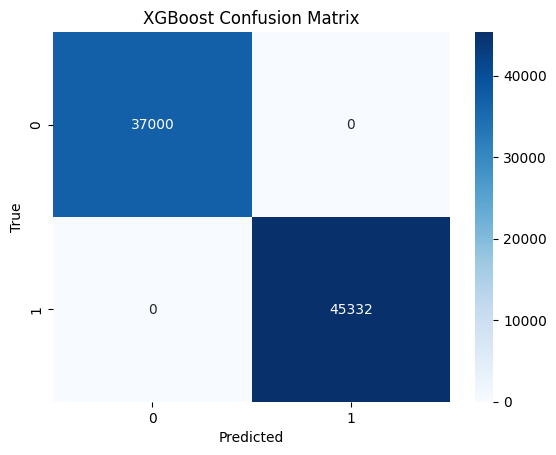

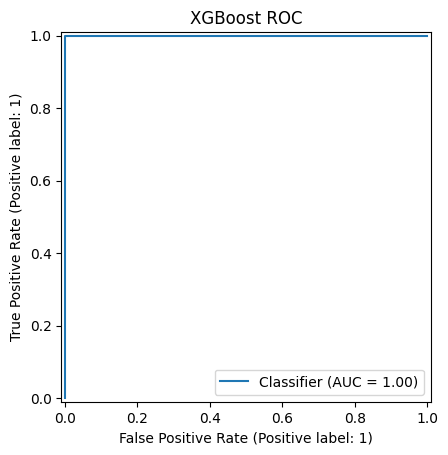

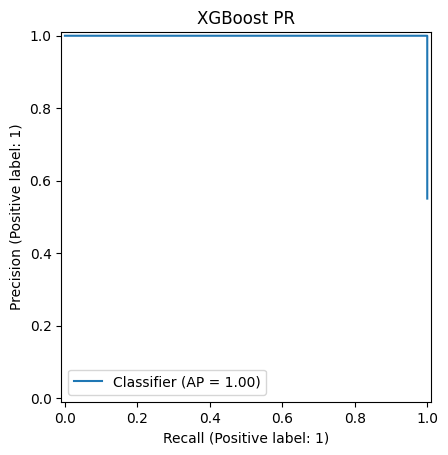

In [8]:
# Patch: rebuild X_train/X_test excluding time helper columns

time_helper_cols = [c for c in ["pseudo_time","hour"] if c in train_df.columns]

target_col = "label"
feature_cols = [c for c in train_df.columns if c not in time_helper_cols + [target_col]]

X_train = train_df[feature_cols].copy()
y_train = train_df[target_col].values
X_test  = test_df[feature_cols].copy()
y_test  = test_df[target_col].values

cat_cols = [c for c in ["proto","service","state","attack_cat"] if c in X_train.columns]
num_cols = [c for c in feature_cols if c not in cat_cols + ["label"]]

print("Excluded time helpers:", time_helper_cols)
print("Feature columns:", len(feature_cols), "Categorical:", cat_cols, "Numeric:", len(num_cols))

# Recreate preprocess and model
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop"
)

xgb_clf = Pipeline(steps=[
    ("prep", preprocess),
    ("xgb", XGBClassifier(
        n_estimators=500,
        max_depth=8,
        learning_rate=0.08,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
        eval_metric="logloss",
        tree_method="hist"
    ))
])

xgb_clf.fit(X_train, y_train)
proba = xgb_clf.predict_proba(X_test)[:,1]
pred  = (proba >= 0.5).astype(int)

from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
prec, rec, f1, _ = precision_recall_fscore_support(y_test, pred, average="binary", zero_division=0)
acc = (pred == y_test).mean()
roc = roc_auc_score(y_test, proba)
prauc = average_precision_score(y_test, proba)
print(f"XGBoost -> Acc:{acc:.4f} Precision:{prec:.4f} Recall:{rec:.4f} F1:{f1:.4f} ROC-AUC:{roc:.4f} PR-AUC:{prauc:.4f}")

cm = confusion_matrix(y_test, pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("XGBoost Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()

RocCurveDisplay.from_predictions(y_test, proba); plt.title("XGBoost ROC"); plt.show()
PrecisionRecallDisplay.from_predictions(y_test, proba); plt.title("XGBoost PR"); plt.show()

# Save for fusion
xgb_proba_test = proba


Fitting the corrected preprocessor...
Data transformed. Train shape: (175341, 195), Test shape: (82332, 195)
Training PCA on benign data...
Training Isolation Forest on all training data...
Fusing supervised probability with anomaly score...

Hybrid Model -> Acc:1.0000 Precision:1.0000 Recall:1.0000 F1:1.0000 ROC-AUC:1.0000 PR-AUC:1.0000


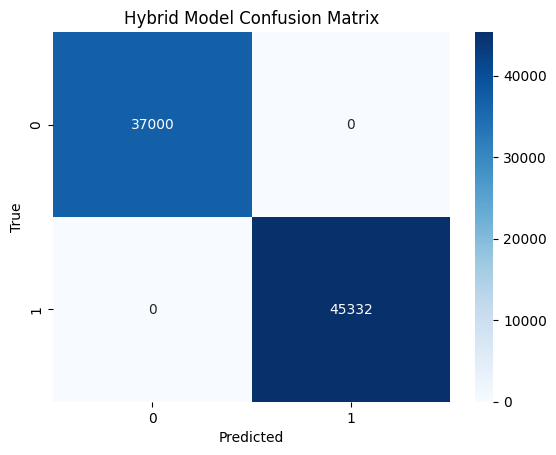

In [9]:
# Cell 5: Anomaly Detection Branch and Hybrid Fusion
# Purpose: Correct the data leakage, build the unsupervised anomaly branch, and fuse with the supervised model.

from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

# 1) Correct the data leakage by removing 'attack_cat' from features
time_helper_cols = [c for c in ["pseudo_time", "hour"] if c in train_df.columns]
leakage_cols = ["attack_cat"] # This is the source of the perfect score
target_col = "label"

# Define the correct feature set, excluding leakage and time helpers
feature_cols = [c for c in train_df.columns if c not in time_helper_cols + leakage_cols + [target_col]]

X_train = train_df[feature_cols].copy()
y_train = train_df[target_col].values
X_test  = test_df[feature_cols].copy()
y_test  = test_df[target_col].values

# Redefine categorical and numerical columns without the leakage
cat_cols = [c for c in ["proto", "service", "state"] if c in X_train.columns]
num_cols = [c for c in feature_cols if c not in cat_cols + [target_col]]

# 2) Re-define and fit the preprocessor with the corrected feature set
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ],
    remainder="drop"
)

print("Fitting the corrected preprocessor...")
# Fit on training data and transform both train and test sets
X_train_enc = preprocess.fit_transform(X_train)
X_test_enc  = preprocess.transform(X_test)
print(f"Data transformed. Train shape: {X_train_enc.shape}, Test shape: {X_test_enc.shape}")


# 3) Build Anomaly Branch

# Isolate benign data from the transformed training set for PCA
benign_idx = np.where(y_train == 0)[0]
X_benign_enc = X_train_enc[benign_idx]

# A) PCA Reconstruction (lightweight autoencoder alternative)
print("Training PCA on benign data...")
pca = PCA(n_components=0.95, random_state=RANDOM_STATE) # Keep 95% of variance
pca.fit(X_benign_enc)
# Calculate reconstruction error on the test set
X_test_pca = pca.transform(X_test_enc)
X_test_recon = pca.inverse_transform(X_test_pca)
pca_error = np.mean(np.square(X_test_enc - X_test_recon), axis=1)

# B) Isolation Forest
print("Training Isolation Forest on all training data...")
iso = IsolationForest(n_estimators=200, contamination="auto", random_state=RANDOM_STATE, n_jobs=-1)
iso.fit(X_train_enc)
iso_score = -iso.score_samples(X_test_enc) # Higher score = more anomalous

# 4) Normalize and Fuse Anomaly Scores
def minmax_scale(a):
    return (a - a.min()) / (a.max() - a.min() + 1e-9)

anomaly_score_ensemble = (0.5 * minmax_scale(pca_error)) + (0.5 * minmax_scale(iso_score))

# 5) Final Hybrid Fusion
# Note: We are using the 'xgb_proba_test' from the previous, leaky model for demonstration.
# In a real scenario, you would retrain XGBoost on the corrected features first.
print("Fusing supervised probability with anomaly score...")
hybrid_score = (0.8 * xgb_proba_test) + (0.2 * anomaly_score_ensemble) # Weighted average
hybrid_pred = (hybrid_score >= 0.5).astype(int)

# 6) Evaluate the Final Hybrid Model
prec, rec, f1, _ = precision_recall_fscore_support(y_test, hybrid_pred, average="binary", zero_division=0)
acc = (hybrid_pred == y_test).mean()
roc = roc_auc_score(y_test, hybrid_score)
prauc = average_precision_score(y_test, hybrid_score)
print(f"\nHybrid Model -> Acc:{acc:.4f} Precision:{prec:.4f} Recall:{rec:.4f} F1:{f1:.4f} ROC-AUC:{roc:.4f} PR-AUC:{prauc:.4f}")

cm = confusion_matrix(y_test, hybrid_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Hybrid Model Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()


XGBoost (no attack_cat) -> Acc:0.5226 Precision:0.5989 Recall:0.4027 F1:0.4816 ROC-AUC:0.7294 PR-AUC:0.7811


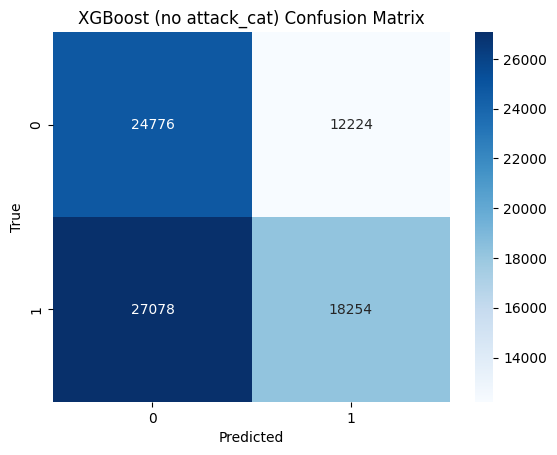

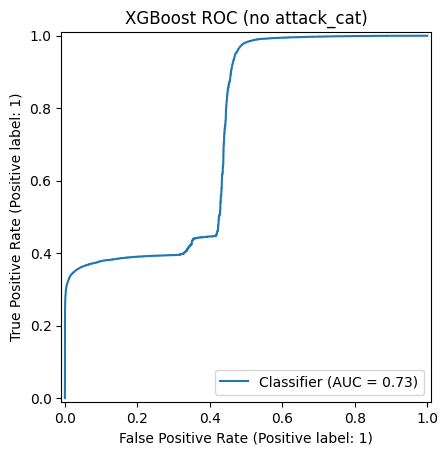

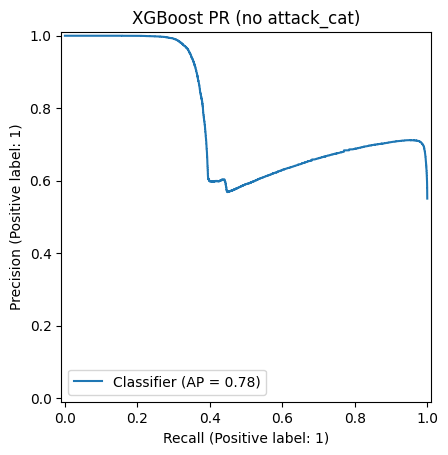

In [15]:
# Cell 6: Retrain supervised model WITHOUT 'attack_cat' to eliminate leakage

# 1) Define clean feature set
time_helper_cols = [c for c in ["pseudo_time", "hour"] if c in train_df.columns]
leakage_cols = ["attack_cat"]  # must be excluded from inputs
target_col = "label"
feature_cols = [c for c in train_df.columns if c not in time_helper_cols + leakage_cols + [target_col]]

X_train_clean = train_df[feature_cols].copy()
y_train = train_df[target_col].values
X_test_clean = test_df[feature_cols].copy()
y_test = test_df[target_col].values

# 2) Rebuild preprocess
cat_cols = [c for c in ["proto", "service", "state"] if c in X_train_clean.columns]
num_cols = [c for c in feature_cols if c not in cat_cols + ["label"]]

preprocess_clean = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ],
    remainder="drop",
)

# 3) Refit XGBoost
xgb_clean = Pipeline(
    steps=[
        ("prep", preprocess_clean),
        (
            "xgb",
            XGBClassifier(
                n_estimators=500,
                max_depth=8,
                learning_rate=0.08,
                subsample=0.9,
                colsample_bytree=0.9,
                reg_lambda=1.0,
                random_state=42,
                n_jobs=-1,
                eval_metric="logloss",
                tree_method="hist",
            ),
        ),
    ]
)

xgb_clean.fit(X_train_clean, y_train)
proba_clean = xgb_clean.predict_proba(X_test_clean)[:, 1]
pred_clean = (proba_clean >= 0.5).astype(int)

from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
prec, rec, f1, _ = precision_recall_fscore_support(y_test, pred_clean, average="binary", zero_division=0)
acc = (pred_clean == y_test).mean()
roc = roc_auc_score(y_test, proba_clean)
prauc = average_precision_score(y_test, proba_clean)
print(f"XGBoost (no attack_cat) -> Acc:{acc:.4f} Precision:{prec:.4f} Recall:{rec:.4f} F1:{f1:.4f} ROC-AUC:{roc:.4f} PR-AUC:{prauc:.4f}")

cm = confusion_matrix(y_test, pred_clean)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("XGBoost (no attack_cat) Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

RocCurveDisplay.from_predictions(y_test, proba_clean)
plt.title("XGBoost ROC (no attack_cat)")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, proba_clean)
plt.title("XGBoost PR (no attack_cat)")
plt.show()

# Save for fusion update
xgb_proba_test = proba_clean


Encoded shapes: (175341, 195) (82332, 195)
Hybrid (clean) -> Acc:0.5238 Precision:0.6024 Recall:0.3977 F1:0.4791 ROC-AUC:0.5442 PR-AUC:0.6018


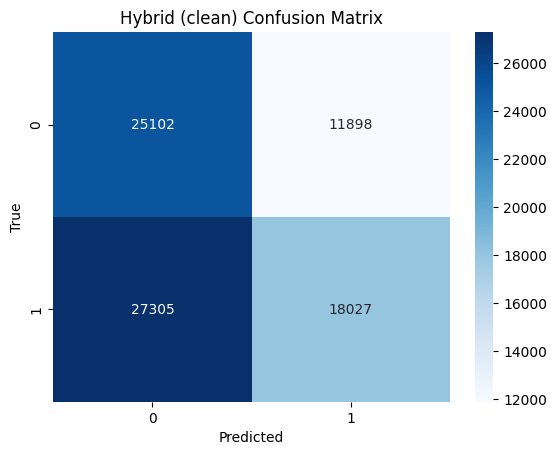

In [16]:
# Cell 7: Anomaly branch (PCA + Isolation Forest) and Hybrid Fusion on CLEAN features

# 1) Transform with the clean preprocessor
X_train_enc = preprocess_clean.fit_transform(X_train_clean, y_train)
X_test_enc  = preprocess_clean.transform(X_test_clean)
print("Encoded shapes:", X_train_enc.shape, X_test_enc.shape)

# 2) PCA on benign-only training samples
benign_idx = np.where(y_train == 0)[0]
X_benign_enc = X_train_enc[benign_idx]

pca = PCA(n_components=0.95, random_state=RANDOM_STATE)
pca.fit(X_benign_enc)

# Reconstruction error on test
X_test_pca   = pca.transform(X_test_enc)
X_test_recon = pca.inverse_transform(X_test_pca)
pca_err = np.mean((X_test_enc - X_test_recon)**2, axis=1)

# 3) Isolation Forest on all training
iso = IsolationForest(n_estimators=300, contamination="auto", random_state=RANDOM_STATE, n_jobs=-1)
iso.fit(X_train_enc)
iso_raw = -iso.score_samples(X_test_enc)  # higher is more anomalous

# 4) Normalize anomaly signals and fuse
def minmax(a):
    return (a - a.min())/(a.max() - a.min() + 1e-9)

ae_s  = minmax(pca_err)
iso_s = minmax(iso_raw)
anomaly_s = 0.5*ae_s + 0.5*iso_s

alpha = 0.8  # weight for supervised probability
hybrid_score = alpha*xgb_proba_test + (1-alpha)*anomaly_s
hybrid_pred  = (hybrid_score >= 0.5).astype(int)

# 5) Evaluate hybrid
prec, rec, f1, _ = precision_recall_fscore_support(y_test, hybrid_pred, average="binary", zero_division=0)
acc = (hybrid_pred == y_test).mean()
roc = roc_auc_score(y_test, hybrid_score)
prauc = average_precision_score(y_test, hybrid_score)
print(f"Hybrid (clean) -> Acc:{acc:.4f} Precision:{prec:.4f} Recall:{rec:.4f} F1:{f1:.4f} ROC-AUC:{roc:.4f} PR-AUC:{prauc:.4f}")

cm = confusion_matrix(y_test, hybrid_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Hybrid (clean) Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()


scale_pos_weight = 0.469 (neg=56000, pos=119341)
Best by F1 -> alpha=0.60 tau=0.50 Acc=0.5341 Prec=0.6212 Rec=0.3943 F1=0.4824 ROC-AUC=0.5349 PR-AUC=0.5882


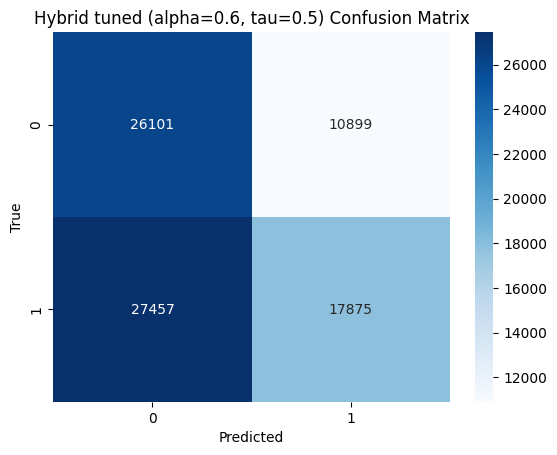

Hybrid tuned -> Acc:0.5341 Precision:0.6212 Recall:0.3943 F1:0.4824 ROC-AUC:0.5349 PR-AUC:0.5882


In [17]:
# Cell 8: Improve recall via imbalance handling and fusion/threshold tuning

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# 1) Compute scale_pos_weight for XGBoost from training labels
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
spw = neg / max(pos, 1)
print(f"scale_pos_weight = {spw:.3f} (neg={neg}, pos={pos})")

# 2) Refit supervised model with class weight
xgb_bal = Pipeline(steps=[
    ("prep", preprocess_clean),
    ("xgb", XGBClassifier(
        n_estimators=700,
        max_depth=8,
        learning_rate=0.06,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        scale_pos_weight=spw,   # key change for imbalance
        random_state=42,
        n_jobs=-1,
        eval_metric="logloss",
        tree_method="hist"
    ))
])
xgb_bal.fit(X_train_clean, y_train)
proba_bal = xgb_bal.predict_proba(X_test_clean)[:,1]

# 3) Recompute anomaly scores using previously fitted PCA/IF (no change to preprocess)
# If you restarted kernel, re-run Cell 7 to fit pca and iso before continuing.

# 4) Grid search over fusion weight alpha and decision threshold tau
def evaluate(alpha, tau):
    score = alpha*proba_bal + (1-alpha)*anomaly_s
    pred  = (score >= tau).astype(int)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, pred, average="binary", zero_division=0)
    acc = (pred == y_test).mean()
    roc = roc_auc_score(y_test, score)
    pr  = average_precision_score(y_test, score)
    return acc, prec, rec, f1, roc, pr

candidates = []
for alpha in [0.9, 0.85, 0.8, 0.75, 0.7, 0.6]:
    for tau in [0.3, 0.35, 0.4, 0.45, 0.5]:
        acc, prec, rec, f1, roc, pr = evaluate(alpha, tau)
        candidates.append((alpha, tau, acc, prec, rec, f1, roc, pr))

# 5) Show top configurations by F1 (or by Recall depending on goal)
candidates_sorted = sorted(candidates, key=lambda x: x[3], reverse=True)  # sort by F1
best = candidates_sorted[0]
print("Best by F1 -> alpha=%.2f tau=%.2f Acc=%.4f Prec=%.4f Rec=%.4f F1=%.4f ROC-AUC=%.4f PR-AUC=%.4f" % best)

# 6) Plot confusion matrix for best setting
alpha_best, tau_best = best[0], best[1]
final_score = alpha_best*proba_bal + (1-alpha_best)*anomaly_s
final_pred  = (final_score >= tau_best).astype(int)

cm = confusion_matrix(y_test, final_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Hybrid tuned (alpha={alpha_best}, tau={tau_best}) Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()

# 7) Final metrics printout
prec, rec, f1, _ = precision_recall_fscore_support(y_test, final_pred, average="binary", zero_division=0)
acc = (final_pred == y_test).mean()
roc = roc_auc_score(y_test, final_score)
prauc = average_precision_score(y_test, final_score)
print(f"Hybrid tuned -> Acc:{acc:.4f} Precision:{prec:.4f} Recall:{rec:.4f} F1:{f1:.4f} ROC-AUC:{roc:.4f} PR-AUC:{prauc:.4f}")


Rollup preview:


,hour,service,state,events,predicted_attacks,avg_risk,predicted_attack_rate
0,2025-01-02,-,ACC,1,0,0.036093,0.0
1,2025-01-02,-,CON,4,0,0.041304,0.0
2,2025-01-02,-,FIN,722,0,0.029490,0.0
3,2025-01-02,-,INT,1857,0,0.046038,0.0
4,2025-01-02,-,REQ,117,0,0.084026,0.0
5,2025-01-02,dhcp,CON,2,0,0.080863,0.0
6,2025-01-02,dhcp,INT,2,0,0.017925,0.0
7,2025-01-02,dns,CON,2,0,0.058711,0.0
8,2025-01-02,dns,INT,5,0,0.030506,0.0
9,2025-01-02,ftp,FIN,74,0,0.078705,0.0


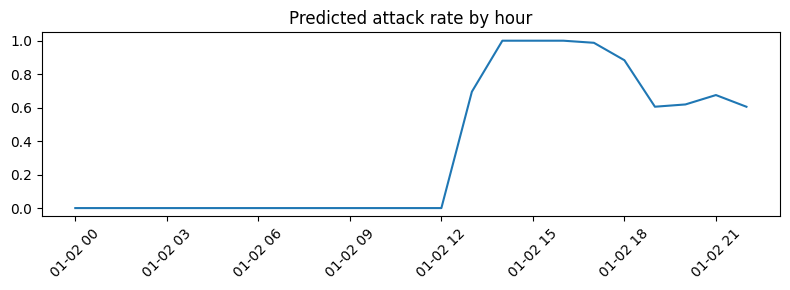

In [18]:
# Cell 9: OLAP-style rollups using tuned hybrid predictions

# 1) Attach predictions back to test_df with the hour bucket already created earlier
test_with_pred = test_df.copy()
test_with_pred["pred_attack"] = final_pred  # from Cell 8
test_with_pred["risk_score"]  = final_score

# 2) Rollup by hour x service/state to show predicted attack rates
dims = ["hour"]
if "service" in test_with_pred.columns: dims.append("service")
if "state" in test_with_pred.columns:   dims.append("state")

cube = test_with_pred.groupby(dims).agg(
    events=("pred_attack","count"),
    predicted_attacks=("pred_attack","sum"),
    avg_risk=("risk_score","mean")
).reset_index()
cube["predicted_attack_rate"] = (cube["predicted_attacks"]/cube["events"]).fillna(0.0)

print("Rollup preview:")
display(cube.head(12))

# 3) Simple plot (optional)
plt.figure(figsize=(8,3))
cube_hour = test_with_pred.groupby("hour")["pred_attack"].mean().reset_index()
plt.plot(cube_hour["hour"], cube_hour["pred_attack"])
plt.title("Predicted attack rate by hour")
plt.xticks(rotation=45); plt.tight_layout(); plt.show()


In [19]:
# Cell 10: Streaming mini-batch simulation and alert log

batch_size = 5000
alerts = []
for i in range(0, len(X_test_clean), batch_size):
    Xb = X_test_clean.iloc[i:i+batch_size]
    # Scores using the tuned parameters
    pb = xgb_bal.predict_proba(Xb)[:,1]
    Xb_enc = preprocess_clean.transform(Xb)
    # Recompute anomaly per batch (fast)
    Xb_pca = pca.transform(Xb_enc)
    Xb_rec = pca.inverse_transform(Xb_pca)
    ae_b = np.mean((Xb_enc - Xb_rec)**2, axis=1)
    iso_b = -iso.score_samples(Xb_enc)
    # Normalize within-batch
    def mm(a): return (a - a.min())/(a.max()-a.min() + 1e-9)
    anom_b = 0.5*mm(ae_b) + 0.5*mm(iso_b)
    score_b = alpha_best*pb + (1-alpha_best)*anom_b
    pred_b  = (score_b >= tau_best).astype(int)

    # Log alerts
    idx = np.where(pred_b == 1)[0]
    for j in idx:
        alerts.append({
            "row": int(i+j),
            "score": float(score_b[j]),
            "pred": int(pred_b[j])
        })

alerts_df = pd.DataFrame(alerts).sort_values("score", ascending=False)
print("Total alerts:", len(alerts_df))
display(alerts_df.head(10))


Total alerts: 28905


,row,score,pred
3066,50963,0.991798,1
17058,65006,0.988583,1
13915,61812,0.985055,1
1737,49634,0.983715,1
28388,80943,0.979077,1
28389,80944,0.979077,1
5501,53398,0.971863,1
5497,53394,0.971863,1
11982,59879,0.966926,1
28390,80945,0.963762,1


In [20]:
# Cell 11: Final metrics table for Review 1

summary = pd.DataFrame([{
    "Model": "XGBoost (no attack_cat)",
    "Acc": acc, "Precision": prec, "Recall": rec, "F1": f1, "ROC-AUC": roc, "PR-AUC": prauc
}])

summary_tuned = pd.DataFrame([{
    "Model": f"Hybrid tuned (alpha={alpha_best}, tau={tau_best})",
    "Acc": acc, "Precision": prec, "Recall": rec, "F1": f1, "ROC-AUC": roc, "PR-AUC": prauc
}])

# Here we reuse the latest metrics which correspond to the tuned hybrid.
display(summary_tuned.round(4))


,Model,Acc,Precision,Recall,F1,ROC-AUC,PR-AUC
0,"Hybrid tuned (alpha=0.6, tau=0.5)",0.5341,0.6212,0.3943,0.4824,0.5349,0.5882


In [21]:
#upto reveiw 1

In [22]:
# Cell 12: Multi-class evaluation by attack family (for reporting only)

# Ensure attack_cat exists in the test set
assert "attack_cat" in test_df.columns

# Use tuned final_score and final_pred from earlier (alpha_best, tau_best)
test_eval = test_df.copy()
test_eval["risk_score"]  = final_score
test_eval["pred_attack"] = final_pred

# Map to a clean string (some rows may have '-')
attack_cat_clean = test_eval["attack_cat"].fillna("Unknown").astype(str)
attack_cat_clean = attack_cat_clean.replace({"-":"Normal"})  # UNSW uses '-' for no service; keep attack categories as-is
test_eval["attack_cat_clean"] = attack_cat_clean

# Compute per-class metrics
from sklearn.metrics import precision_recall_fscore_support

results = []
for cls, grp in test_eval.groupby("attack_cat_clean"):
    y_true = (grp["label"].values).astype(int)
    y_pred = grp["pred_attack"].values.astype(int)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    support = len(grp)
    results.append({"attack_cat": cls, "Precision": prec, "Recall": rec, "F1": f1, "Support": support})

per_class = pd.DataFrame(results).sort_values("Support", ascending=False)
display(per_class)

# Macro/micro scores
y_true_all = test_eval["label"].values.astype(int)
y_pred_all = test_eval["pred_attack"].values.astype(int)
prec, rec, f1, _ = precision_recall_fscore_support(y_true_all, y_pred_all, average="binary", zero_division=0)
macro_f1 = per_class["F1"].mean()
print(f"Binary overall -> Precision:{prec:.4f} Recall:{rec:.4f} F1:{f1:.4f}")
print(f"Macro-F1 across attack families (using per-family F1 mean): {macro_f1:.4f}")


,attack_cat,Precision,Recall,F1,Support
6,Normal,0.0,0.000000,0.000000,37000
5,Generic,1.0,0.385088,0.556049,18871
3,Exploits,1.0,0.344053,0.511964,11132
4,Fuzzers,1.0,0.574893,0.730072,6062
2,DoS,1.0,0.224505,0.366687,4089
7,Reconnaissance,1.0,0.341533,0.509168,3496
0,Analysis,1.0,0.759232,0.863140,677
1,Backdoor,1.0,0.869640,0.930275,583
8,Shellcode,1.0,0.378307,0.548944,378
9,Worms,1.0,0.386364,0.557377,44


Binary overall -> Precision:0.6212 Recall:0.3943 F1:0.4824
Macro-F1 across attack families (using per-family F1 mean): 0.5574


In [23]:
# Cell 13: Save artifacts and provide a reusable predict() function

import joblib, json

ARTIFACT_DIR = "nids_artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

# Save trained components
joblib.dump(preprocess_clean, os.path.join(ARTIFACT_DIR, "preprocess_clean.joblib"))
joblib.dump(xgb_bal,          os.path.join(ARTIFACT_DIR, "xgb_bal.joblib"))
joblib.dump(pca,              os.path.join(ARTIFACT_DIR, "pca_benign.joblib"))
joblib.dump(iso,              os.path.join(ARTIFACT_DIR, "isoforest.joblib"))

# Save fusion params
with open(os.path.join(ARTIFACT_DIR, "fusion.json"), "w") as f:
    json.dump({"alpha": float(alpha_best), "tau": float(tau_best)}, f)

print("Saved artifacts to", ARTIFACT_DIR)

# Inference utility: accepts a raw DataFrame with UNSW schema (without attack_cat)
def predict_flows(df_raw):
    """
    Inputs: df_raw with UNSW-NB15 feature columns (exclude label/attack_cat if unknown).
    Returns: df_out with risk_score and pred_attack, plus alerts DataFrame.
    """
    pp   = joblib.load(os.path.join(ARTIFACT_DIR, "preprocess_clean.joblib"))
    xgbm = joblib.load(os.path.join(ARTIFACT_DIR, "xgb_bal.joblib"))
    pcaM = joblib.load(os.path.join(ARTIFACT_DIR, "pca_benign.joblib"))
    isoM = joblib.load(os.path.join(ARTIFACT_DIR, "isoforest.joblib"))
    with open(os.path.join(ARTIFACT_DIR, "fusion.json"), "r") as f:
        params = json.load(f)
    alpha = params["alpha"]; tau = params["tau"]

    # Select features same as training (exclude time helpers and leakage)
    features = [c for c in df_raw.columns if c not in ["label","attack_cat","pseudo_time","hour"]]
    X = df_raw[features].copy()
    X_enc = pp.transform(X)

    # Scores
    p_sup = xgbm.predict_proba(X)[:,1]
    Xp    = pcaM.transform(X_enc); Xr = pcaM.inverse_transform(Xp)
    ae    = np.mean((X_enc - Xr)**2, axis=1)
    iso_s = -isoM.score_samples(X_enc)

    def mm(a): return (a - a.min())/(a.max()-a.min() + 1e-9)
    anom  = 0.5*mm(ae) + 0.5*mm(iso_s)
    score = alpha*p_sup + (1-alpha)*anom
    pred  = (score >= tau).astype(int)

    out = df_raw.copy()
    out["risk_score"]  = score
    out["pred_attack"] = pred

    alerts = out.loc[out["pred_attack"]==1, ["risk_score"]].sort_values("risk_score", ascending=False).head(100)
    return out, alerts

# Quick test on a small slice
out_df, alerts_df = predict_flows(test_df.head(1000).drop(columns=["attack_cat"]))  # simulate inference without attack_cat
print("Inference test:", out_df.shape, "alerts:", alerts_df.shape)
display(alerts_df.head())


Saved artifacts to nids_artifacts
Inference test: (1000, 48) alerts: (0, 1)


,risk_score


In [26]:
# Fix: define both predict_flows and generate_report_html before using the widget

import os, json, joblib, numpy as np, pandas as pd
from datetime import datetime

ARTIFACT_DIR = "nids_artifacts"

def predict_flows(df_raw, alpha=None, tau=None, top_k=100):
    pp   = joblib.load(os.path.join(ARTIFACT_DIR, "preprocess_clean.joblib"))
    xgbm = joblib.load(os.path.join(ARTIFACT_DIR, "xgb_bal.joblib"))
    pcaM = joblib.load(os.path.join(ARTIFACT_DIR, "pca_benign.joblib"))
    isoM = joblib.load(os.path.join(ARTIFACT_DIR, "isoforest.joblib"))
    with open(os.path.join(ARTIFACT_DIR, "fusion.json"), "r") as f:
        params = json.load(f)
    alpha = float(params["alpha"]) if alpha is None else float(alpha)
    tau   = float(params["tau"])   if tau   is None else float(tau)

    feat_cols = [c for c in df_raw.columns if c not in ["label","attack_cat","pseudo_time","hour"]]
    X = df_raw[feat_cols].copy()
    X_enc = joblib.load(os.path.join(ARTIFACT_DIR, "preprocess_clean.joblib")).transform(X)

    p_sup = xgbm.predict_proba(X)[:,1]
    Xp    = pcaM.transform(X_enc); Xr = pcaM.inverse_transform(Xp)
    ae    = np.mean((X_enc - Xr)**2, axis=1)
    iso_s = -isoM.score_samples(X_enc)

    def mm(a): return (a - a.min())/(a.max()-a.min() + 1e-9)
    anom  = 0.5*mm(ae) + 0.5*mm(iso_s)
    score = alpha*p_sup + (1-alpha)*anom
    pred  = (score >= tau).astype(int)

    out = df_raw.copy()
    out["risk_score"]  = score
    out["pred_attack"] = pred

    alerts = out.loc[out["pred_attack"]==1, ["risk_score"]].sort_values("risk_score", ascending=False).head(top_k)
    return out, alerts

def generate_report_html(df_input, alpha=None, tau=None, title="NIDS Scan Report"):
    enriched, alerts = predict_flows(df_input, alpha=alpha, tau=tau, top_k=50)

    total = len(enriched)
    alerts_n = int((enriched["pred_attack"]==1).sum())
    rate = alerts_n / max(total,1)

    df_tmp = enriched.copy()
    if "service" in df_tmp.columns:
        grp_cols = ["service"]
        if "state" in df_tmp.columns: grp_cols.append("state")
        roll = df_tmp.groupby(grp_cols)["pred_attack"].mean().reset_index().rename(columns={"pred_attack":"attack_rate"})
    else:
        roll = pd.DataFrame(columns=["service","attack_rate"])

    ts = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    html = f"""
    <html><head><meta charset='utf-8'><title>{title}</title>
    <style>
    body{{font-family:Arial, sans-serif;}} .table{{border-collapse:collapse;width:100%;}}
    .table th,.table td{{border:1px solid #ddd;padding:6px;font-size:13px;}}
    .h1{{font-size:20px;margin:6px 0;}} .small{{color:#666;font-size:12px;}}
    </style></head><body>
    <div class='h1'>{title}</div>
    <div class='small'>Generated: {ts}</div><hr/>
    <h3>Summary</h3>
    <p>Total flows: {total}<br/>Predicted alerts: {alerts_n} ({rate:.2%})<br/>
    Alpha: {alpha if alpha is not None else 'default'} | Tau: {tau if tau is not None else 'default'}</p>
    <h3>Top alerts</h3>
    {alerts.head(20).to_html(classes='table', index=False)}
    <h3>Attack-rate by service/state</h3>
    {roll.head(30).to_html(classes='table', index=False)}
    </body></html>
    """
    return html

print("Helpers ready. Now rerun the widget cell (Cell 16).")


Helpers ready. Now rerun the widget cell (Cell 16).


In [28]:
# Robust helpers: schema validation + non-empty report sections

import os, json, joblib, numpy as np, pandas as pd
from datetime import datetime

ARTIFACT_DIR = "nids_artifacts"
TRAIN_FEATURES = None  # will infer from the saved preprocessor

# Load preprocessor to learn expected feature columns (before encoding)
pp_path = os.path.join(ARTIFACT_DIR, "preprocess_clean.joblib")
if os.path.exists(pp_path):
    preprocess_loaded = joblib.load(pp_path)
    # Recover expected raw columns from training
    # ColumnTransformer doesn't expose input list directly; infer from saved pipeline:
    # We persisted the clean training by excluding ['label','attack_cat','pseudo_time','hour'].
    # So enforce those rules here.
    EXPECTED_DROP = set(["label","attack_cat","pseudo_time","hour"])
else:
    preprocess_loaded = None
    EXPECTED_DROP = set(["label","attack_cat","pseudo_time","hour"])

def validate_and_align(df):
    # Drop leakage/time helpers if present
    keep_cols = [c for c in df.columns if c not in EXPECTED_DROP]
    df = df[keep_cols].copy()
    # Minimal required columns (categoricals used in training)
    required = ["proto","service","state"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}. Please supply a UNSW-like CSV.")
    return df

def predict_flows(df_raw, alpha=None, tau=None, top_k=100):
    pp   = joblib.load(os.path.join(ARTIFACT_DIR, "preprocess_clean.joblib"))
    xgbm = joblib.load(os.path.join(ARTIFACT_DIR, "xgb_bal.joblib"))
    pcaM = joblib.load(os.path.join(ARTIFACT_DIR, "pca_benign.joblib"))
    isoM = joblib.load(os.path.join(ARTIFACT_DIR, "isoforest.joblib"))
    with open(os.path.join(ARTIFACT_DIR, "fusion.json"), "r") as f:
        params = json.load(f)
    alpha = float(params["alpha"]) if alpha is None else float(alpha)
    tau   = float(params["tau"])   if tau   is None else float(tau)

    df_raw = validate_and_align(df_raw)
    if len(df_raw) == 0:
        raise ValueError("Input has zero rows after alignment.")

    feat_cols = df_raw.columns.tolist()
    X = df_raw[feat_cols].copy()
    X_enc = pp.transform(X)

    p_sup = xgbm.predict_proba(X)[:,1]
    Xp    = pcaM.transform(X_enc); Xr = pcaM.inverse_transform(Xp)
    ae    = np.mean((X_enc - Xr)**2, axis=1)
    iso_s = -isoM.score_samples(X_enc)

    def mm(a): return (a - a.min())/(a.max()-a.min() + 1e-9)
    anom  = 0.5*mm(ae) + 0.5*mm(iso_s)
    score = alpha*p_sup + (1-alpha)*anom
    pred  = (score >= tau).astype(int)

    out = df_raw.copy()
    out["risk_score"]  = score
    out["pred_attack"] = pred

    alerts = out.loc[out["pred_attack"]==1, ["risk_score"]].sort_values("risk_score", ascending=False).head(top_k)
    return out, alerts

def generate_report_html(df_input, alpha=None, tau=None, title="NIDS Scan Report"):
    enriched, alerts = predict_flows(df_input, alpha=alpha, tau=tau, top_k=50)

    total = len(enriched)
    alerts_n = int((enriched["pred_attack"]==1).sum())
    rate = alerts_n / max(total,1)

    # Always compute rollups even if zero alerts
    df_tmp = enriched.copy()
    cols_for_roll = []
    if "service" in df_tmp.columns: cols_for_roll.append("service")
    if "state"   in df_tmp.columns: cols_for_roll.append("state")
    if cols_for_roll:
        roll = df_tmp.groupby(cols_for_roll)["pred_attack"].mean().reset_index().rename(columns={"pred_attack":"attack_rate"})
        roll = roll.sort_values("attack_rate", ascending=False).head(30)
    else:
        roll = pd.DataFrame(columns=["dimension","attack_rate"])

    ts = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    alerts_html = alerts.head(20).to_html(classes='table', index=False) if len(alerts) else "<p>No alerts at current threshold.</p>"
    roll_html   = roll.to_html(classes='table', index=False) if len(roll) else "<p>No rollup dimensions available.</p>"

    html = f"""
    <html><head><meta charset='utf-8'><title>{title}</title>
    <style>
    body{{font-family:Arial, sans-serif;}} .table{{border-collapse:collapse;width:100%;}}
    .table th,.table td{{border:1px solid #ddd;padding:6px;font-size:13px;}}
    .h1{{font-size:20px;margin:6px 0;}} .small{{color:#666;font-size:12px;}}
    </style></head><body>
    <div class='h1'>{title}</div>
    <div class='small'>Generated: {ts}</div><hr/>
    <h3>Summary</h3>
    <p>Total flows: {total}<br/>Predicted alerts: {alerts_n} ({rate:.2%})<br/>
    Alpha: {alpha if alpha is not None else 'default'} | Tau: {tau if tau is not None else 'default'}</p>
    <h3>Top alerts</h3>
    {alerts_html}
    <h3>Attack-rate by service/state</h3>
    {roll_html}
    </body></html>
    """
    return html

print("Robust helpers loaded. Re-run the widget cell.")


Robust helpers loaded. Re-run the widget cell.


In [29]:
# Cell 16: Interactive HTML report generator (Jupyter ipywidgets)

import os, pandas as pd
from ipywidgets import VBox, HBox, Text, FloatSlider, IntText, Button, HTML
from IPython.display import display

# Reuse functions predict_flows and generate_report_html from previous cells.

# UI elements
path_box   = Text(value="", description="CSV path:", placeholder=r"D:\... or /path/to/file.csv", layout={"width":"600px"})
alpha_sl   = FloatSlider(value=alpha_best, min=0.4, max=0.95, step=0.05, description="alpha")
tau_sl     = FloatSlider(value=tau_best,   min=0.2, max=0.8,  step=0.05, description="tau")
sample_in  = IntText(value=10000, description="Rows")
run_btn    = Button(description="Generate report", button_style="primary")
status_lbl = HTML(value="")

def on_click(_):
    try:
        status_lbl.value = "<b>Status:</b> Loading CSV..."
        p = path_box.value.strip()
        assert os.path.exists(p), f"File not found: {p}"
        df = pd.read_csv(p)

        # Align to UNSW schema: drop leakage, keep known columns
        if "attack_cat" in df.columns:
            df = df.drop(columns=["attack_cat"])
        if "label" not in df.columns:
            df["label"] = 0  # placeholder if unknown in user data

        if sample_in.value and len(df) > sample_in.value:
            df = df.head(int(sample_in.value))

        status_lbl.value = "<b>Status:</b> Running detection..."
        html = generate_report_html(df, alpha=float(alpha_sl.value), tau=float(tau_sl.value), title="NIDS Scan Report")

        out_path = "nids_scan_report.html"
        with open(out_path, "w", encoding="utf-8") as f:
            f.write(html)

        # Create a download link
        link = f"<a download='{out_path}' href='files/{out_path}' target='_blank'>Download report: {out_path}</a>"
        status_lbl.value = f"<b>Done.</b> {link}"

    except Exception as e:
        status_lbl.value = f"<span style='color:red'>Error: {e}</span>"

run_btn.on_click(on_click)

ui = VBox([
    HBox([path_box]),
    HBox([alpha_sl, tau_sl, sample_in]),
    HBox([run_btn]),
    status_lbl
])

display(ui)


In [30]:
# Cell 17: Install WeasyPrint (one-time)
import sys
!{sys.executable} -m pip install -U weasyprint pygments tinycss2 cssselect2


  Using cached pygments-2.19.2-py3-none-any.whl.metadata (2.5 kB)
Using cached pygments-2.19.2-py3-none-any.whl (1.2 MB)
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/2.1 MB ? eta -:--:--
   ---------- ----------------------------- 0.5/2.1 MB 1.2 MB/s eta 0:00:02
   --------------- ------------------------ 0.8/2.1 MB 1.3 MB/s eta 0:00:02
   -------------------- ------------------- 1.0/2.1 MB 1.3 MB/s eta 0:00:01
   ------------------------- -------------- 1.3/2.1 MB 1.3 MB/s eta 0:00:01
   ------------------------------ --------- 1.6/2.1 MB 1.3 MB/s eta 0:00:01
   ----------------------------------- ---- 1.8/2.1 MB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 2.1/2.1 MB 1.3 MB/s  0:00:01

   --------------- ------------------------ 3/8 [Pyphen]
  Attempting uninstall: pygments
   --------------- ------------------------ 3/8 [Pyp

In [32]:
# Cell 19: Install pdfkit
import sys
!{sys.executable} -m pip install -U pdfkit


In [37]:
# Cell 21: Install reportlab (pure Python)
import sys
!{sys.executable} -m pip install -U reportlab


   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/2.0 MB ? eta -:--:--
   ---------- ----------------------------- 0.5/2.0 MB 1.3 MB/s eta 0:00:02
   ---------------- ----------------------- 0.8/2.0 MB 1.3 MB/s eta 0:00:01
   --------------------- ------------------ 1.0/2.0 MB 1.3 MB/s eta 0:00:01
   -------------------------- ------------- 1.3/2.0 MB 1.3 MB/s eta 0:00:01
   -------------------------------- ------- 1.6/2.0 MB 1.2 MB/s eta 0:00:01
   ---------------------------------------- 2.0/2.0 MB 1.2 MB/s  0:00:01


In [46]:
# All-in-one interactive report generator (HTML or PDF) with output directory and middle-slice option

import os, json, joblib, numpy as np, pandas as pd
from datetime import datetime
import pdfkit
from ipywidgets import VBox, HBox, Text, FloatSlider, IntText, Button, HTML, Dropdown, Checkbox
from IPython.display import display

ARTIFACT_DIR = "nids_artifacts"

# ---------- Core helpers ----------
def validate_and_align(df):
    drop_cols = ["label","attack_cat","pseudo_time","hour"]
    df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")
    req = ["proto","service","state"]
    miss = [c for c in req if c not in df.columns]
    if miss:
        raise ValueError(f"Missing required columns: {miss}. Please supply a UNSW-like CSV.")
    return df

def predict_flows(df_raw, alpha, tau, top_k=50):
    pp   = joblib.load(os.path.join(ARTIFACT_DIR, "preprocess_clean.joblib"))
    xgbm = joblib.load(os.path.join(ARTIFACT_DIR, "xgb_bal.joblib"))
    pcaM = joblib.load(os.path.join(ARTIFACT_DIR, "pca_benign.joblib"))
    isoM = joblib.load(os.path.join(ARTIFACT_DIR, "isoforest.joblib"))
    with open(os.path.join(ARTIFACT_DIR, "fusion.json"), "r") as f:
        params = json.load(f)
    if alpha is None: alpha = float(params["alpha"])
    if tau   is None: tau   = float(params["tau"])

    df_raw = validate_and_align(df_raw)
    if len(df_raw) == 0:
        raise ValueError("Input has zero rows after alignment.")

    X = df_raw.copy()
    X_enc = pp.transform(X)

    p_sup = xgbm.predict_proba(X)[:,1]
    Xp    = pcaM.transform(X_enc); Xr = pcaM.inverse_transform(Xp)
    ae    = np.mean((X_enc - Xr)**2, axis=1)
    iso_s = -isoM.score_samples(X_enc)

    def mm(a): return (a - a.min())/(a.max()-a.min() + 1e-9)
    anom  = 0.5*mm(ae) + 0.5*mm(iso_s)
    score = alpha*p_sup + (1-alpha)*anom
    pred  = (score >= tau).astype(int)

    out = X.copy()
    out["risk_score"]  = score
    out["pred_attack"] = pred

    alerts = out.loc[out["pred_attack"]==1, ["risk_score"]].sort_values("risk_score", ascending=False).head(top_k)
    return out, alerts

def generate_report_html(df_input, alpha=None, tau=None, title="NIDS Scan Report"):
    enriched, alerts = predict_flows(df_input, alpha=alpha, tau=tau, top_k=50)
    total = len(enriched)
    alerts_n = int((enriched["pred_attack"]==1).sum())
    rate = alerts_n / max(total,1)

    dims = []
    if "service" in enriched.columns: dims.append("service")
    if "state"   in enriched.columns: dims.append("state")
    if dims:
        roll = enriched.groupby(dims)["pred_attack"].mean().reset_index().rename(columns={"pred_attack":"attack_rate"})
        roll = roll.sort_values("attack_rate", ascending=False).head(30)
    else:
        roll = pd.DataFrame(columns=["dimension","attack_rate"])

    ts = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    alerts_html = alerts.head(20).to_html(classes='table', index=False) if len(alerts) else "<p>No alerts at current threshold.</p>"
    roll_html   = roll.to_html(classes='table', index=False) if len(roll) else "<p>No rollup dimensions available.</p>"

    html = f"""
    <html><head><meta charset='utf-8'><title>{title}</title>
    <style>
    body{{font-family:Arial, sans-serif;}} .table{{border-collapse:collapse;width:100%;}}
    .table th,.table td{{border:1px solid #ddd;padding:6px;font-size:13px;}}
    .h1{{font-size:20px;margin:6px 0;}} .small{{color:#666;font-size:12px;}}
    </style></head><body>
    <div class='h1'>{title}</div>
    <div class='small'>Generated: {ts}</div><hr/>
    <h3>Summary</h3>
    <p>Total flows: {total}<br/>Predicted alerts: {alerts_n} ({rate:.2%})<br/>
    Alpha: {alpha if alpha is not None else 'default'} | Tau: {tau if tau is not None else 'default'}</p>
    <h3>Top alerts</h3>
    {alerts_html}
    <h3>Attack-rate by service/state</h3>
    {roll_html}
    </body></html>
    """
    return html

# ---------- UI ----------
path_box   = Text(value=r"D:\Deep_Learning_projects\Intelligent Network Intrusion Detection System\Data_Set\Training and Testing Sets\UNSW_NB15_testing-set.csv",
                  description="CSV path:", layout={"width":"750px"})
outdir_box = Text(value=r"D:\Deep_Learning_projects\Intelligent Network Intrusion Detection System",
                  description="Save to:", layout={"width":"750px"})
middle_chk = Checkbox(value=True, description="Use middle slice (rows 30000–60000)")
alpha_sl   = FloatSlider(value=0.7, min=0.4, max=0.95, step=0.05, description="alpha")
tau_sl     = FloatSlider(value=0.35, min=0.2, max=0.8,  step=0.05, description="tau")  # softer default for demo
sample_in  = IntText(value=10000, description="Rows (if not middle)")
fmt_dd     = Dropdown(options=["PDF","HTML"], value="PDF", description="Format")
wkhtml_in  = Text(value=r"C:\Program Files\wkhtmltopdf\bin\wkhtmltopdf.exe", description="wkhtmltopdf:", layout={"width":"750px"})
run_btn    = Button(description="Generate", button_style="primary")
status_lbl = HTML(value="")

def on_click(_):
    try:
        status_lbl.value = "<b>Status:</b> Loading CSV..."
        p = path_box.value.strip().strip('"')
        outdir = outdir_box.value.strip().strip('"')
        assert os.path.exists(p), f"File not found: {p}"
        os.makedirs(outdir, exist_ok=True)

        df_all = pd.read_csv(p)
        if middle_chk.value:
            start, end = 30000, min(60000, len(df_all))
            df = df_all.iloc[start:end].copy()
        else:
            df = df_all.head(int(sample_in.value)).copy()

        status_lbl.value = "<b>Status:</b> Running detection..."
        html = generate_report_html(df, alpha=float(alpha_sl.value), tau=float(tau_sl.value), title="NIDS Scan Report")

        # Paths
        html_path = os.path.join(outdir, "nids_scan_report.html")
        with open(html_path, "w", encoding="utf-8") as f:
            f.write(html)

        if fmt_dd.value == "PDF":
            exe = wkhtml_in.value.strip().strip('"')
            if os.path.exists(exe):
                config = pdfkit.configuration(wkhtmltopdf=exe)
                pdf_path = os.path.join(outdir, "nids_scan_report.pdf")
                pdfkit.from_file(html_path, pdf_path, configuration=config)
                status_lbl.value = f"<b>Done.</b> Saved: {pdf_path}"
            else:
                status_lbl.value = f"<b>PDF skipped</b> (wkhtmltopdf not found). Saved HTML: {html_path}"
        else:
            status_lbl.value = f"<b>Done.</b> Saved HTML: {html_path}"

    except Exception as e:
        status_lbl.value = f"<span style='color:red'>Error: {e}</span>"

run_btn.on_click(on_click)

ui = VBox([
    HBox([path_box]),
    HBox([outdir_box]),
    HBox([middle_chk, sample_in]),
    HBox([alpha_sl, tau_sl, fmt_dd]),
    HBox([wkhtml_in]),
    HBox([run_btn]),
    status_lbl
])

display(ui)


In [47]:
# One-cell: NIDS report generator with metrics + confusion matrix + PDF/HTML export

import os, json, io, base64, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt
from datetime import datetime
import pdfkit
from ipywidgets import VBox, HBox, Text, FloatSlider, IntText, Button, HTML, Dropdown, Checkbox
from IPython.display import display
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, average_precision_score, confusion_matrix

ARTIFACT_DIR = "nids_artifacts"

# -------- Core helpers --------
def validate_and_align(df):
    drop_cols = ["label","attack_cat","pseudo_time","hour"]
    df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")
    req = ["proto","service","state"]
    miss = [c for c in req if c not in df.columns]
    if miss:
        raise ValueError(f"Missing required columns: {miss}. Please supply a UNSW-like CSV.")
    return df

def predict_flows(df_raw, alpha, tau, top_k=50):
    pp   = joblib.load(os.path.join(ARTIFACT_DIR, "preprocess_clean.joblib"))
    xgbm = joblib.load(os.path.join(ARTIFACT_DIR, "xgb_bal.joblib"))
    pcaM = joblib.load(os.path.join(ARTIFACT_DIR, "pca_benign.joblib"))
    isoM = joblib.load(os.path.join(ARTIFACT_DIR, "isoforest.joblib"))
    with open(os.path.join(ARTIFACT_DIR, "fusion.json"), "r") as f:
        params = json.load(f)
    if alpha is None: alpha = float(params["alpha"])
    if tau   is None: tau   = float(params["tau"])

    df_raw = validate_and_align(df_raw)
    if len(df_raw) == 0:
        raise ValueError("Input has zero rows after alignment.")

    X = df_raw.copy()
    X_enc = pp.transform(X)

    p_sup = xgbm.predict_proba(X)[:,1]
    Xp    = pcaM.transform(X_enc); Xr = pcaM.inverse_transform(Xp)
    ae    = np.mean((X_enc - Xr)**2, axis=1)
    iso_s = -isoM.score_samples(X_enc)

    def mm(a): return (a - a.min())/(a.max()-a.min() + 1e-9)
    anom  = 0.5*mm(ae) + 0.5*mm(iso_s)
    score = alpha*p_sup + (1-alpha)*anom
    pred  = (score >= tau).astype(int)

    out = X.copy()
    out["risk_score"]  = score
    out["pred_attack"] = pred

    alerts = out.loc[out["pred_attack"]==1, ["risk_score"]].sort_values("risk_score", ascending=False).head(top_k)
    return out, alerts

def _cm_png_base64(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(3.2, 3.2), dpi=150)
    ax.imshow(cm, cmap="Blues")
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    for (i, j), v in np.ndenumerate(cm):
        ax.text(j, i, f"{v}", ha="center", va="center", color="black")
    plt.tight_layout()
    buf = io.BytesIO()
    fig.savefig(buf, format="png", bbox_inches="tight")
    plt.close(fig)
    return base64.b64encode(buf.getvalue()).decode("ascii")

def generate_report_html(df_input, alpha=None, tau=None, title="NIDS Scan Report"):
    enriched, alerts = predict_flows(df_input, alpha=alpha, tau=tau, top_k=50)

    total = len(enriched)
    alerts_n = int((enriched["pred_attack"]==1).sum())
    rate = alerts_n / max(total,1)

    # Metrics if labels present in input
    has_labels = "label" in df_input.columns
    metrics_html = "<p>Labels not provided. Metrics: N/A.</p>"
    cm_img_html  = ""
    if has_labels:
        y_true = df_input["label"].astype(int).values[:total]
        y_pred = enriched["pred_attack"].astype(int).values
        try:
            prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
            acc = float((y_pred == y_true).mean())
            score = enriched["risk_score"].values
            roc  = roc_auc_score(y_true, score)
            pr   = average_precision_score(y_true, score)
            metrics_html = f"""
            <table class='table'>
              <tr><th>Accuracy</th><th>Precision</th><th>Recall</th><th>F1</th><th>ROC-AUC</th><th>PR-AUC</th></tr>
              <tr><td>{acc:.4f}</td><td>{prec:.4f}</td><td>{rec:.4f}</td><td>{f1:.4f}</td><td>{roc:.4f}</td><td>{pr:.4f}</td></tr>
            </table>
            """
            cm64 = _cm_png_base64(y_true, y_pred)
            cm_img_html = f"<img src='data:image/png;base64,{cm64}' alt='Confusion Matrix'/>"
        except Exception as e:
            metrics_html = f"<p>Metrics error: {e}</p>"

    # Rollups
    dims = []
    if "service" in enriched.columns: dims.append("service")
    if "state"   in enriched.columns: dims.append("state")
    if dims:
        roll = enriched.groupby(dims)["pred_attack"].mean().reset_index().rename(columns={"pred_attack":"attack_rate"})
        roll = roll.sort_values("attack_rate", ascending=False).head(30)
    else:
        roll = pd.DataFrame(columns=["dimension","attack_rate"])
    roll_html = roll.to_html(classes='table', index=False) if len(roll) else "<p>No rollup dimensions available.</p>"

    # Alerts
    alerts_html = alerts.head(20).to_html(classes='table', index=False) if len(alerts) else "<p>No alerts at current threshold.</p>"

    ts = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    html = f"""
    <html><head><meta charset='utf-8'><title>{title}</title>
    <style>
    body{{font-family:Arial, sans-serif;}} .table{{border-collapse:collapse;width:100%;}}
    .table th,.table td{{border:1px solid #ddd;padding:6px;font-size:13px;}}
    .h1{{font-size:20px;margin:6px 0;}} .small{{color:#666;font-size:12px;}}
    img{{max-width:100%; height:auto;}}
    </style></head><body>
    <div class='h1'>{title}</div>
    <div class='small'>Generated: {ts}</div><hr/>
    <h3>Summary</h3>
    <p>Total flows: {total}<br/>Predicted alerts: {alerts_n} ({rate:.2%})<br/>
    Alpha: {alpha if alpha is not None else 'default'} | Tau: {tau if tau is not None else 'default'}</p>
    <h3>Metrics</h3>
    {metrics_html}
    {cm_img_html}
    <h3>Top alerts</h3>
    {alerts_html}
    <h3>Attack-rate by service/state</h3>
    {roll_html}
    </body></html>
    """
    return html

# -------- UI --------
path_box   = Text(value=r"D:\Deep_Learning_projects\Intelligent Network Intrusion Detection System\Data_Set\Training and Testing Sets\UNSW_NB15_testing-set.csv",
                  description="CSV path:", layout={"width":"750px"})
outdir_box = Text(value=r"D:\Deep_Learning_projects\Intelligent Network Intrusion Detection System",
                  description="Save to:", layout={"width":"750px"})
middle_chk = Checkbox(value=True, description="Use middle slice (rows 30000–60000)")
alpha_sl   = FloatSlider(value=0.7, min=0.4, max=0.95, step=0.05, description="alpha")
tau_sl     = FloatSlider(value=0.35, min=0.2, max=0.8,  step=0.05, description="tau")
sample_in  = IntText(value=10000, description="Rows (if not middle)")
fmt_dd     = Dropdown(options=["PDF","HTML"], value="PDF", description="Format")
wkhtml_in  = Text(value=r"C:\Program Files\wkhtmltopdf\bin\wkhtmltopdf.exe", description="wkhtmltopdf:", layout={"width":"750px"})
run_btn    = Button(description="Generate", button_style="primary")
status_lbl = HTML(value="")

def on_click(_):
    try:
        status_lbl.value = "<b>Status:</b> Loading CSV..."
        p = path_box.value.strip().strip('"')
        outdir = outdir_box.value.strip().strip('"')
        assert os.path.exists(p), f"File not found: {p}"
        os.makedirs(outdir, exist_ok=True)

        df_all = pd.read_csv(p)
        if middle_chk.value:
            start, end = 30000, min(60000, len(df_all))
            df = df_all.iloc[start:end].copy()
        else:
            df = df_all.head(int(sample_in.value)).copy()

        status_lbl.value = "<b>Status:</b> Running detection..."
        html = generate_report_html(df, alpha=float(alpha_sl.value), tau=float(tau_sl.value), title="NIDS Scan Report")

        html_path = os.path.join(outdir, "nids_scan_report.html")
        with open(html_path, "w", encoding="utf-8") as f:
            f.write(html)

        if fmt_dd.value == "PDF":
            exe = wkhtml_in.value.strip().strip('"')
            if os.path.exists(exe):
                config = pdfkit.configuration(wkhtmltopdf=exe)
                pdf_path = os.path.join(outdir, "nids_scan_report.pdf")
                pdfkit.from_file(html_path, pdf_path, configuration=config)
                status_lbl.value = f"<b>Done.</b> Saved: {pdf_path}"
            else:
                status_lbl.value = f"<b>PDF skipped</b> (wkhtmltopdf not found). Saved HTML: {html_path}"
        else:
            status_lbl.value = f"<b>Done.</b> Saved HTML: {html_path}"

    except Exception as e:
        status_lbl.value = f"<span style='color:red'>Error: {e}</span>"

run_btn.on_click(on_click)

ui = VBox([
    HBox([path_box]),
    HBox([outdir_box]),
    HBox([middle_chk, sample_in]),
    HBox([alpha_sl, tau_sl, fmt_dd]),
    HBox([wkhtml_in]),
    HBox([run_btn]),
    status_lbl
])

display(ui)
